In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/data/groups/jeltema/zhou/lsst_shear/WeakLensingDeblending/bin')
sys.path.append('/data/groups/jeltema/zhou/lsst_shear/WeakLensingDeblending')

In [3]:
import numpy as np
from astropy.io import fits
from astropy.table import Table,vstack
import astropy.table
from tqdm import tqdm,trange
import pickle
import pandas as pd

In [4]:
from gals_wideblend import *

In [5]:
dc2_path = "../data/dc2_table.fits"
dc2 = Table(fits.open(dc2_path)[1].data)

In [6]:
dc2

ra,dec,g_ab,r_ab,i_ab,z_ab,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,pa_disk,pa_bulge,a_d,b_d,a_b,b_b,redshift,galtileid,halo_mass
float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,int64,float64
62.584976621345525,-40.33411037080228,16.389235,15.969118,15.751877,15.644171,0.32269984,0.67730016,0.0,-66.4201,-66.4201,5.6323986,2.33411,2.7313764,1.9987385,0.022012473481028083,9687500000,247261051312.67606
61.398620435512704,-41.03614200764764,19.776192,19.318966,19.032682,18.882126,0.070048705,0.9299513,0.0,-59.92826,-59.92826,1.4281247,1.3844869,0.75730324,0.7565165,0.02072399032633876,9687500001,54657675898.59155
61.02425004128892,-39.78354472426767,17.94235,17.240576,16.882887,16.658743,0.16649516,0.83350486,0.0,-26.887655,-26.887655,3.075085,2.736342,1.5653273,1.5465406,0.020339439398866288,9687500002,119726379988.7324
61.42001365533904,-39.964448298372076,18.457945,17.74149,17.34065,16.9841,0.331346,0.66865396,0.0,-87.74712,-87.74712,4.103955,2.8931146,2.1592422,2.1274288,0.018406557661051925,9687500003,70274166264.78874
61.869596337556686,-40.90712062111757,14.888106,14.139737,13.786592,13.53991,0.9928688,0.007131219,0.0,-94.42553,-94.42553,13.089191,5.7455816,6.417689,5.5446253,0.021333993084020175,9687500004,12069313567729.578
61.752069643381446,-40.92046711520129,20.176435,19.705341,19.467945,19.36302,0.4738952,0.5261048,0.0,-112.66666,-112.66666,2.395142,1.8234566,1.0722445,1.0153674,0.01895143717971748,9687500006,12069313567729.578
61.60264120350098,-41.20686458447872,17.96229,17.473446,17.18892,17.024097,0.15961692,0.84038305,0.0,-82.54127,-82.54127,8.462835,5.3880544,3.269798,3.187262,0.02191538507044788,9687500007,111918134805.6338
61.5046720254966,-40.63557946204719,19.029364,18.327383,17.97854,17.767725,0.2187631,0.7812369,0.0,-40.712093,-40.712093,4.5915895,3.1326065,1.9091964,1.848278,0.021156485886255627,9687500008,72876914659.15494
60.84498169284794,-40.44227265290786,15.998091,15.485788,15.223526,15.067873,0.2056364,0.7943636,0.0,-8.3027725,-8.3027725,4.7573214,1.3834975,2.5237951,2.1348205,0.020922126891235626,9687500009,348768238692.95776


In [7]:
dc2[dc2['galtileid']== 6062516397]

ra,dec,g_ab,r_ab,i_ab,z_ab,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,pa_disk,pa_bulge,a_d,b_d,a_b,b_b,redshift,galtileid,halo_mass
float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,int64,float64
63.71131960320797,-34.07084541695384,19.164318,18.076174,17.574484,17.273684,0.9510996,0.048900425,0.0,-141.12372,-141.12372,0.7599356,0.2848343,0.59322506,0.3033384,0.16630761102881286,6062516397,127786028652169.02


In [8]:
number, bin_edges = np.histogram(np.log10(dc2['halo_mass']),bins=4)
n = number.min()
bin_edges[-1]=100
print(n)
# group galaxies by halo mass bins 
dc2['mass_bin'] = np.digitize(np.log10(dc2['halo_mass']),bin_edges)

error_list = []
mean_list = []
mean_mass_list = []
result_table_combined = dc2
for n_bin in np.unique(result_table_combined['mass_bin']):
    mean_mass_list.append(np.mean(result_table_combined['halo_mass'][result_table_combined['mass_bin'] == n_bin]))

dc2_df = dc2.to_pandas()

subsampled_gal = []
###subsample galaxies in each mass bin
for bin_index in np.unique(dc2_df['mass_bin']):
    bin_gals = dc2_df[dc2_df['mass_bin']==bin_index]
    print(len(bin_gals))
    sub_galaxy=bin_gals.sample(n)
    subsampled_gal.append(sub_galaxy)

214214
184473217
14498669
2611746
214214


In [26]:
data = init_wldeblend(survey_bands='lsst-i')

In [39]:
mean_mass = np.zeros(len(subsampled_gal))
for i,mass_table in enumerate(subsampled_gal):
    mean_mass[i] = np.log10(mass_table['halo_mass'].mean())
print(mean_mass)
np.save('../output/mean_mass.npy',mean_mass)

[10.40617289 11.89314148 13.11307238 14.1981084 ]


In [34]:
for i, mass_table in enumerate(subsampled_gal):
    mass_table = Table.from_pandas(mass_table)
    gal_list = []
    for j in trange(len(mass_table)):
        gal = get_gal_wldeblend(rng=np.random.RandomState(1234), ind=i, data=data)
        id = mass_table[j]['galtileid']
        gal_list.append((gal,id))
    with open('../data/gal_list_{}.pkl'.format(i),'wb') as f:
        pickle.dump(gal_list,f)
    

100%|██████████| 214214/214214 [01:29<00:00, 2406.64it/s]


In [9]:
dc2_subsampled = pd.concat(subsampled_gal)
dc2_subsampled = astropy.table.Table.from_pandas(dc2_subsampled)

In [10]:
mean_mass_list = []
result_table_combined = dc2_subsampled
for n_bin in np.unique(result_table_combined['mass_bin']):
    mean_mass_list.append(np.mean(result_table_combined['halo_mass'][result_table_combined['mass_bin'] == n_bin]))

In [11]:
mean_mass_list

[25478443438.822803, 781882473851.993, 12973954634595.172, 157800510475466.47]

In [13]:
data.noise

420.9240990481278

In [14]:
len(dc2_subsampled)

856856

In [15]:
#save table
dc2_subsampled.write('../data/dc2_subsampled.fits',overwrite=True)

In [16]:
dc2 = Table(fits.open('../data/dc2_subsampled.fits')[1].data)
print(len(dc2))

856856


In [17]:
gal_list = []
for i in trange(len(dc2_subsampled)):
    gal = get_gal_wldeblend(rng=np.random.RandomState(1234), ind=i, data=data)
    id = dc2_subsampled[i]['galtileid']
    gal_list.append((gal,id))

 50%|████▉     | 426312/856856 [03:04<03:06, 2309.39it/s]


IndexError: index 426312 is out of bounds for axis 0 with size 426312

In [ ]:
with open('../data/gal_list.pkl','wb') as f:
    pickle.dump(gal_list,f)

In [ ]:
gal = gal_list[0][0].band_galaxies[0].withGSParams(maximum_fft_size=16000)
print(gal)

(galsim.Exponential(scale_radius=0.14765484283171085, flux=38459.83229483947).shear(galsim.Shear(g1=0.0009038525280254034,g2=0.024866338373342154)) + galsim.DeVaucouleurs(half_light_radius=0.1534247255446093, flux=29544.183401007616).shear(galsim.Shear(g1=0.00036912025077793663,g2=0.010155051594920408))).rotate(1.203352196659766 radians)


In [ ]:
import matplotlib.pyplot as plt
import galsim


def plot_gal(i):
    gal = (gal_list[i][0].band_galaxies[0].withGSParams(maximum_fft_size=16000).drawImage(scale=0.2, nx=53,ny=53).array)
    print(gal_list[i][1])
    print(gal.flatten().min())
    plt.imshow(np.log10(gal))
    plt.show()

In [ ]:
gal

galsim.Transformation(galsim.Sum([galsim.Transformation(galsim.Exponential(scale_radius=0.14765484283171085, flux=38459.83229483947, gsparams=galsim.GSParams(128,16000,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), jac=[[1.0012138521657397, 0.024874039968123256], [0.024874039968123256, 0.999405587227827]], offset=galsim.PositionD(x=0.0, y=0.0), flux_ratio=1.0, gsparams=galsim.GSParams(128,16000,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05), propagate_gsparams=True), galsim.Transformation(galsim.DeVaucouleurs(scale_radius=4.4349007117131576e-05, trunc=0.0, flux=29544.183401007616, gsparams=galsim.GSParams(128,16000,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), jac=[[1.000420773970436, 0.01015557594755943], [0.01015557594755943, 0.9996824953500827]], offset=galsim.PositionD(x=0.0, y=0.0), flux_ratio=1.0, gsparams=galsim.GSParams(128,16000,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05), propagate_gsparams=True)], gsparams=g

In [ ]:
gal.drawImage(scale=0.2, nx=53,ny=53).array

array([[0.00796689, 0.00881199, 0.00962047, ..., 0.01034651, 0.00942869,
        0.00851573],
       [0.00877513, 0.00970743, 0.01065347, ..., 0.01148586, 0.01038305,
        0.0093423 ],
       [0.00964662, 0.01065452, 0.011771  , ..., 0.01266357, 0.01144331,
        0.01028989],
       ...,
       [0.01028989, 0.01144331, 0.01266357, ..., 0.011771  , 0.01065452,
        0.00964662],
       [0.0093423 , 0.01038305, 0.01148586, ..., 0.01065347, 0.00970743,
        0.00877513],
       [0.00851573, 0.00942869, 0.01034651, ..., 0.00962047, 0.00881199,
        0.00796689]], dtype=float32)

In [ ]:
import matplotlib.pyplot as plt
import galsim


def plot_gal(i):
    gal = (gal_list[i][0].band_galaxies[0].withGSParams(maximum_fft_size=160000).drawImage(scale=0.2, nx=53,ny=53).array)
    print(gal_list[i][1])
    print(gal.flatten().min())
    plt.imshow(np.log10(gal))
    plt.show()

7937801974
0.105793014


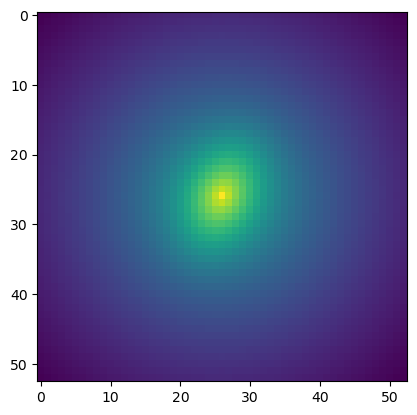

In [ ]:
plot_gal(14)
gal = gal_list[14]

(array([2.798e+03, 6.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.05793014e-01, 7.74983740e+03, 1.54995693e+04, 2.32493008e+04,
        3.09990312e+04, 3.87487656e+04, 4.64984961e+04, 5.42482266e+04,
        6.19979570e+04, 6.97476875e+04, 7.74974219e+04]),
 <BarContainer object of 10 artists>)

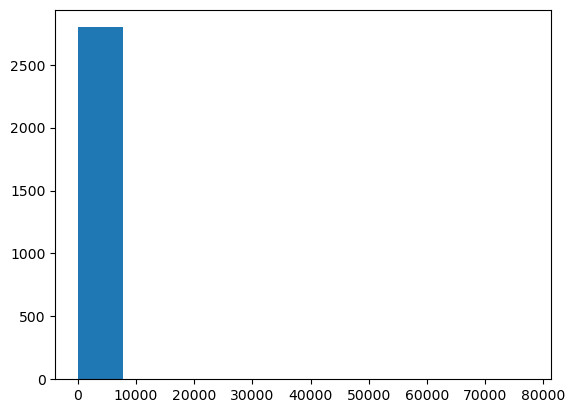

In [ ]:
number = gal[0].band_galaxies[0].drawImage(scale=0.2, nx=53,ny=53).array
plt.hist(number.flatten())

10631428896
0.007966888


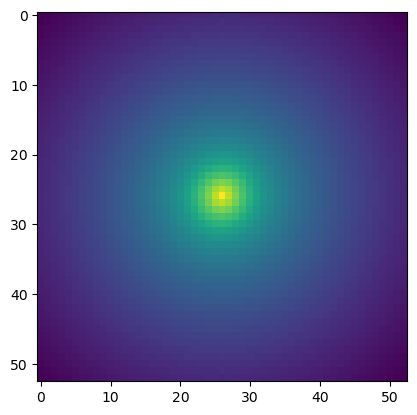

9754008299
0.026255025


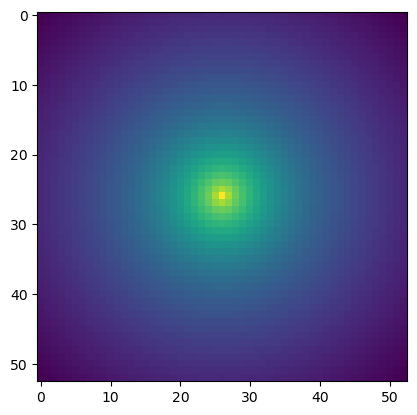

7065013476
3.754609e-05


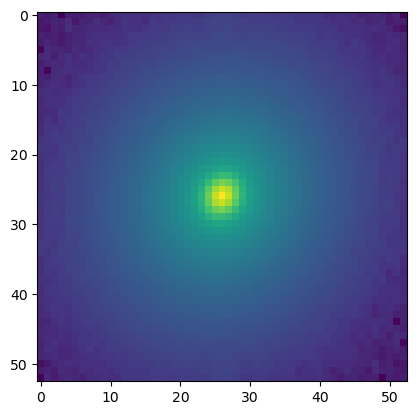

9750436613
0.00023420254


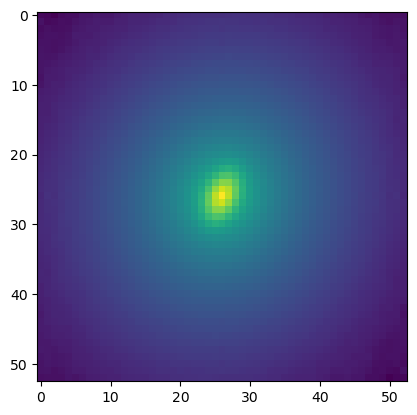

11327942208
0.00029346434


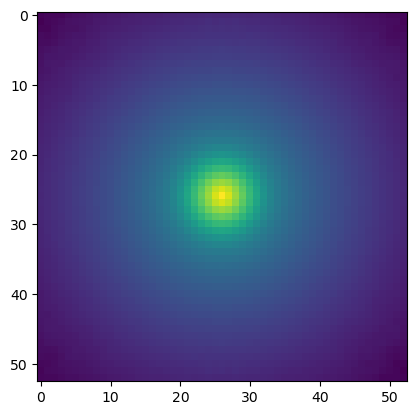

11312748314
0.03088215


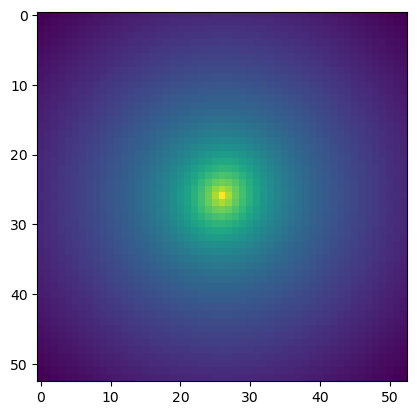

7001690587
0.002634879


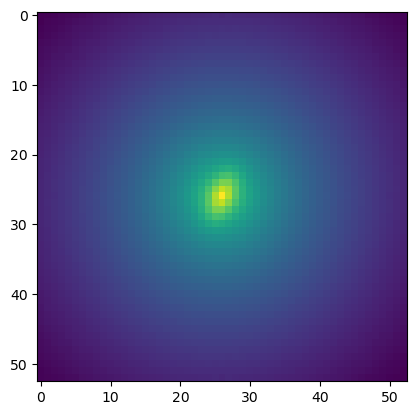

11939416952
0.0008078419


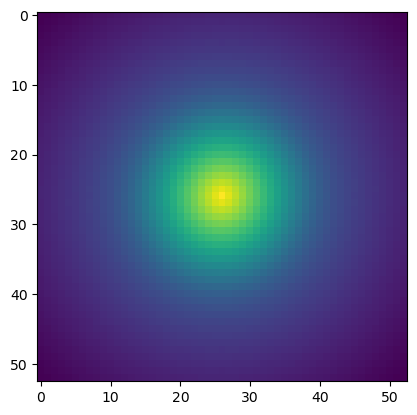

11937526023
7.483862e-05


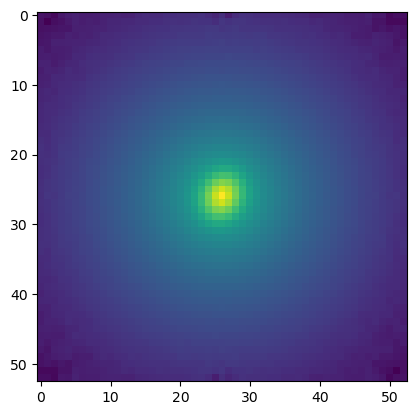

8937524830
0.0005789213


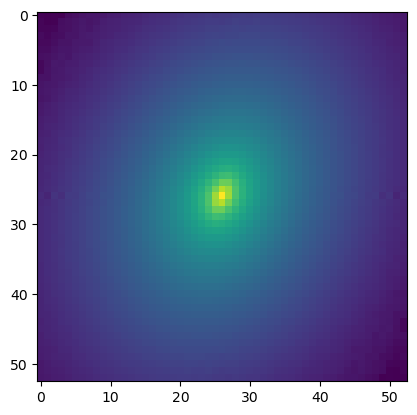

7065035668
-0.0015137043


/tmp/ipykernel_141970/4016499379.py:9: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(gal))


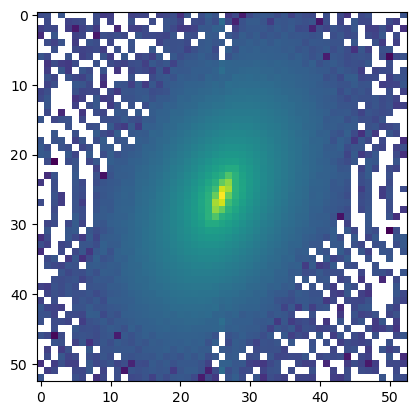

11250887197
-0.0017567489


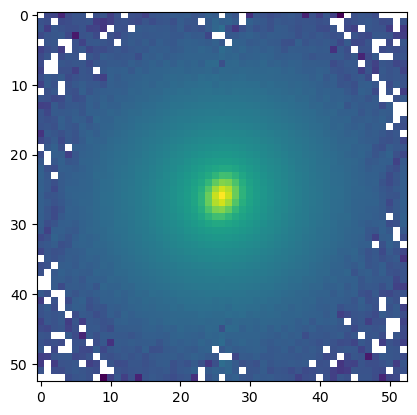

9688374961
0.006941454


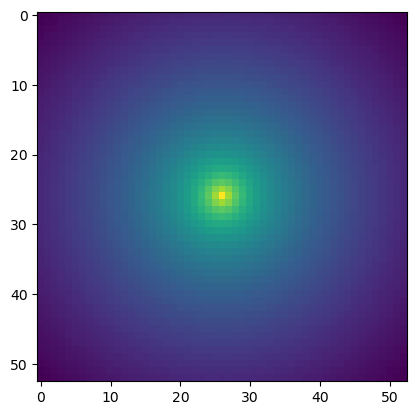

7001416953
0.00012831124


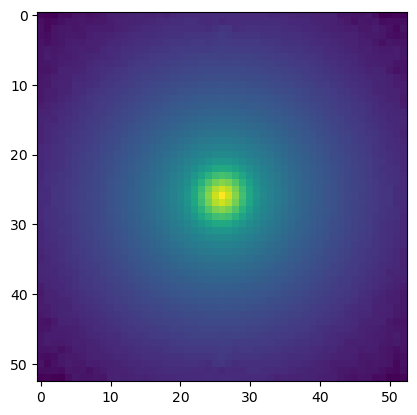

7937801974
0.105793014


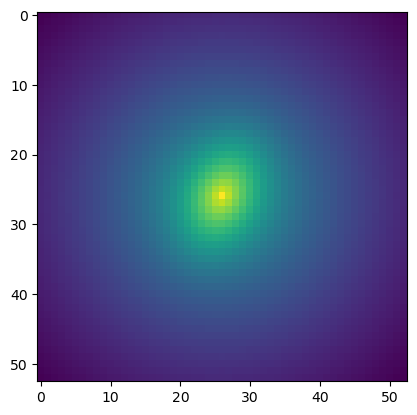

KeyboardInterrupt: 

In [ ]:
for i in range(426300):
    plot_gal(i)

10500450829
-5.3813616e-05


/tmp/ipykernel_29235/1815656971.py:6: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(gal))


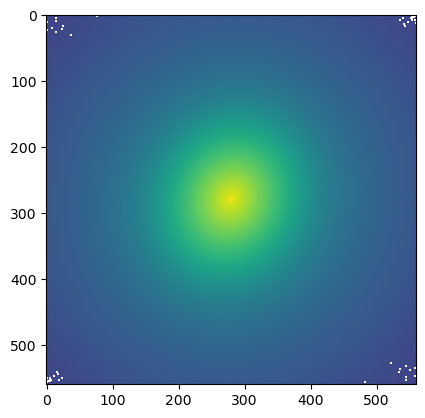

In [ ]:
plot_gal(4)

In [ ]:
dc2[dc2['galtileid'] == 10500450829]

ra,dec,g_ab,r_ab,i_ab,z_ab,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,pa_disk,pa_bulge,a_d,b_d,a_b,b_b,redshift,galtileid,halo_mass,mass_bin
float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,int64,float64,int64
63.09045973838988,-42.32085239893416,27.039055,25.918615,25.56965,25.456654,0.37293038,0.6270696,0.0,-22.987753,-22.987753,0.20719016,0.1159799,0.09284142,0.091700174,0.51056283955128,10500450829,71901483336.5934,1


-0.0010072638


/tmp/ipykernel_29235/635352088.py:5: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(gal))


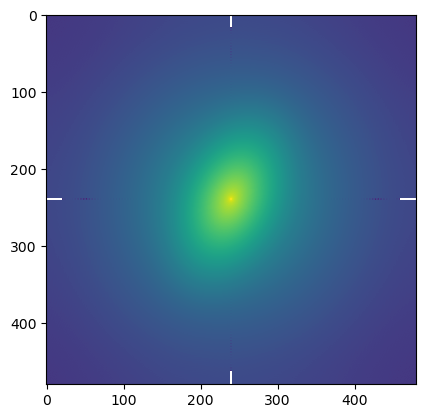

In [ ]:
plot_gal(24)

-0.0051063183


/tmp/ipykernel_29235/635352088.py:5: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(gal))


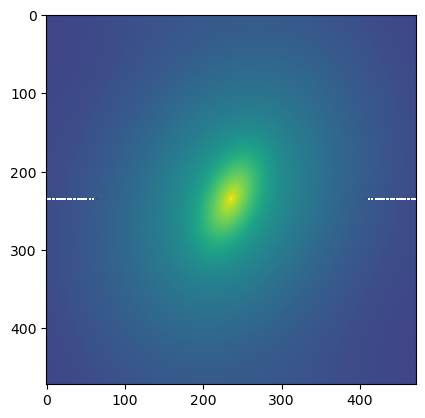

In [ ]:
plot_gal(34)

-0.006585863


/tmp/ipykernel_29235/635352088.py:5: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(gal))


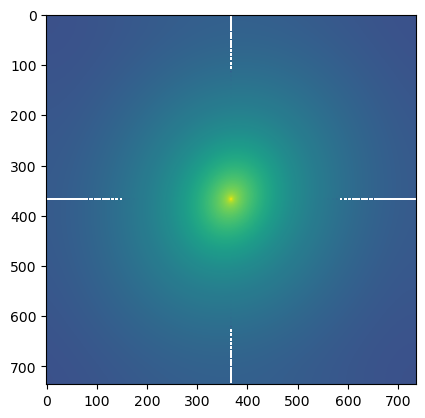

In [ ]:
plot_gal(40)